# Time series analysis
_2020.04.27_

In this project you need to prepare a forecast for an imaginary bank of the number of its active customers and total balance for the next 90 days.

## Installation

**fbProphet installation guide**<br/>
First install _Ephem_:

<code>conda install -c anaconda ephem</code>

Install _Pystan_:

<code>conda install -c conda-forge pystan</code>

Finally install _Fbprophet_:

<code>conda install -c conda-forge fbprophet</code>

Then according to [this](https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10) article replace line 16 in fbprophet/hdays.py:

<code>from holidays import WEEKEND, HolidayBase, easter, rd</code>

to

<code>from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd</code>

## Import

In [4]:
import math

import warnings
import matplotlib

from datetime import date
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from fbprophet import Prophet
from fbprophet.plot import plot
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

warnings.filterwarnings("ignore")

style.use('seaborn-poster')
style.use('ggplot')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
def reduce_memory_usage(df, verbose=True): 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
    start_mem = df.memory_usage().sum() / 1024**2 
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns: 
        col_type = df[col].dtypes 
        if col_type in numerics: 
            c_min = df[col].min() 
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int': 
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max: 
                    df[col] = df[col].astype(np.int8) 
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max: 
                    df[col] = df[col].astype(np.int16) 
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max: 
                    df[col] = df[col].astype(np.int32) 
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max: 
                    df[col] = df[col].astype(np.int64)   
                else: 
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max: 
                        df[col] = df[col].astype(np.float16) 
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max: 
                        df[col] = df[col].astype(np.float32) 
                    else: 
                        df[col] = df[col].astype(np.float64)     
        end_mem = df.memory_usage().sum() / 1024**2 
        if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem)) 
        return df

$MAPE = \frac{\sum \frac{\left | A-F \right |}{A} \times 100}{N}$

$SMAPE = \frac{\sum \frac{\left | A-F \right |}{(|A| + |F|)/2} \times 100}{N}$

In [6]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true)-np.abs(y_pred)/2)))*100

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

## Loading

In [4]:
df_input = pd.read_csv('data/active_customers.csv', dtype='object', usecols=['date', 'value'])

df_input['date'] = pd.to_datetime(df_input['date'])
df_input['value'] = pd.to_numeric(df_input['value'])

df_input['change'] = df_input['value'].diff()
df_input.loc[0, 'change'] = 0
df_input['change'] = pd.to_numeric(df_input['change'])

In [5]:
print("{:,} records and {} features in active customer set.".format(df_input.shape[0], df_input.shape[1]))
df_input = reduce_memory_usage(df_input)

821 records and 3 features in active customer set.
Starting memory usage:  0.02 MB
Reduced memory usage:  0.02 MB (0.0% reduction)


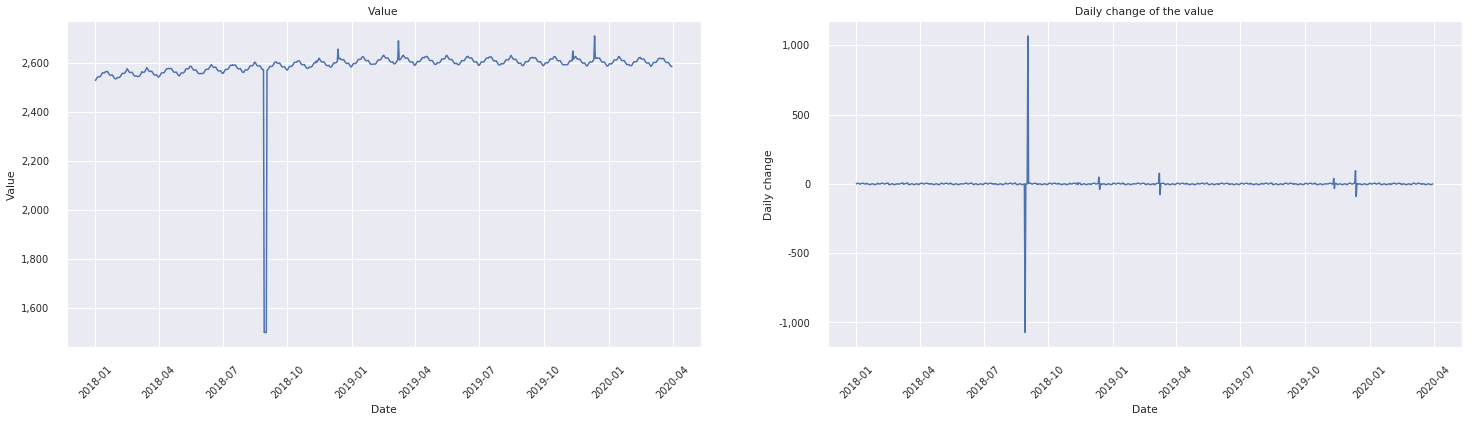

In [6]:
plt.figure(figsize=(25, 6))
sns.set(font_scale=0.9)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=df_input['date'], y=df_input['value'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Value')
ax.set_title('Value')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x=df_input['date'], y=df_input['change'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Daily change')
ax.set_title('Daily change of the value')

plt.show()

## Analyses

### fbProphet

In [7]:
df_input[df_input['value'] < 1600]

,date,value,change
240,2018-08-29,1500.0,-1071.819941
241,2018-08-30,1500.0,0.000000
242,2018-08-31,1500.0,0.000000
243,2018-09-01,1500.0,0.000000


In [8]:
df_input[('2018-08-27' < df_input['date']) & (df_input['date'] < '2018-09-03')]

,date,value,change
239,2018-08-28,2571.819941,0.347785
240,2018-08-29,1500.000000,-1071.819941
241,2018-08-30,1500.000000,0.000000
242,2018-08-31,1500.000000,0.000000
243,2018-09-01,1500.000000,0.000000
244,2018-09-02,2567.914895,1067.914895


In [9]:
#Interpolate the balance values for the wrong values
start = df_input.loc[df_input['date']==datetime.strptime('2018-08-28', '%Y-%m-%d'), 'value'].values[0]
end = df_input.loc[df_input['date']==datetime.strptime('2018-09-02', '%Y-%m-%d'), 'value'].values[0]
df_input.loc[('2018-08-28' < df_input['date']) & (df_input['date'] < '2018-09-02'), 'value'] = (start + end)/2

In [10]:
df_input[('2018-08-27' < df_input['date']) & (df_input['date'] < '2018-09-03')]

,date,value,change
239,2018-08-28,2571.819941,0.347785
240,2018-08-29,2569.867418,-1071.819941
241,2018-08-30,2569.867418,0.000000
242,2018-08-31,2569.867418,0.000000
243,2018-09-01,2569.867418,0.000000
244,2018-09-02,2567.914895,1067.914895


In [11]:
#Compute the new daily changes
df_input['change'] = df_input['value'].diff()
df_input.loc[0, 'change'] = 0
df_input['change'] = pd.to_numeric(df_input['change'], downcast='integer')

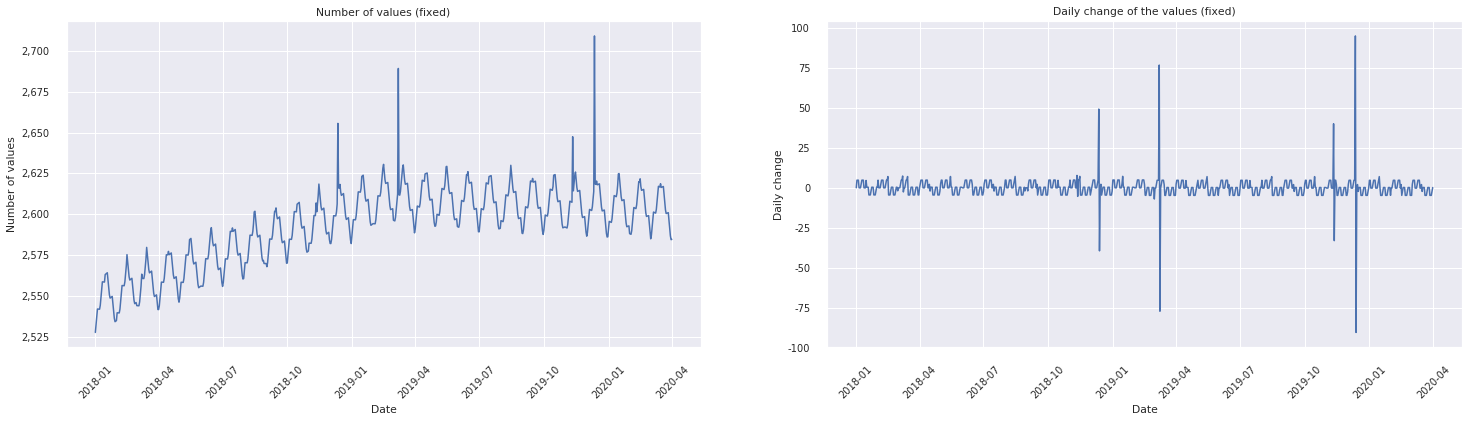

In [12]:
plt.figure(figsize=(25, 6))
sns.set(font_scale=0.9)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=df_input['date'], y=df_input['value'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Number of values')
ax.set_title('Number of values (fixed)')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x=df_input['date'], y=df_input['change'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Daily change')
ax.set_title('Daily change of the values (fixed)')

plt.show()

In [13]:
df_input.sort_values(by='value', ascending=False)[:5]

,date,value,change
710,2019-12-12,2709.077434,95.075021
431,2019-03-08,2689.189229,76.842056
345,2018-12-12,2655.583650,49.282666
679,2019-11-11,2647.423696,40.086489
410,2019-02-15,2630.518176,2.218236


In [18]:
#Special days
special_days = ['2019-12-12', '2019-03-08', '2018-12-12', '2019-11-11']

df_input['special_day'] = 1*(df_input['date'].isin([datetime.strptime(d, '%Y-%m-%d') for d in special_days]))
df_input['special_day_next'] = 1*(df_input['date'].isin([datetime.strptime(d, '%Y-%m-%d') + timedelta(days=1) for d in special_days]))

In [25]:
df_input[340:350]

,date,value,change,special_day,special_day_next
340,2018-12-07,2599.086336,-0.038377,0,0
341,2018-12-08,2599.043647,-0.042689,0,0
342,2018-12-09,2598.996645,-0.047002,0,0
343,2018-12-10,2601.413465,2.416819,0,0
344,2018-12-11,2606.300984,4.887519,0,0
345,2018-12-12,2655.583650,49.282666,1,0
346,2018-12-13,2616.090602,-39.493048,0,1
347,2018-12-14,2616.038085,-0.052517,0,0
348,2018-12-15,2618.244212,2.206127,0,0
349,2018-12-16,2613.659153,-4.585059,0,0


In [26]:
#For this small data set is easier to mark the future days manually
d1 = datetime.strptime('2020-03-08', '%Y-%m-%d')
d2 = datetime.strptime('2020-11-11', '%Y-%m-%d')
df_input.loc[df_input['date'].isin([d1, d2]), 'special_day_next'] = 1

In [27]:
df_input.rename(columns={'date': 'ds', 'change': 'y'}, inplace=True)
m = Prophet(seasonality_mode='additive', yearly_seasonality=False, daily_seasonality=False, interval_width=0.95) #It already has a weekly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=4) #Add monthly seasonality
m.add_country_holidays(country_name='CN') # Country specific public holidays
m.add_regressor('special_day')
m.add_regressor('special_day_next')
m.fit(df_input)

In [29]:
future = m.make_future_dataframe(periods=90)

future_special_day_list = ['2019-12-12', '2019-03-08', '2018-12-12', '2019-11-11', '2020-03-08', '2020-11-11']
future['special_day'] = 1*(future['ds'].isin([datetime.strptime(d, '%Y-%m-%d') for d in future_special_day_list]))
future['special_day_next'] = 1*(future['ds'].isin([datetime.strptime(d, '%Y-%m-%d') + timedelta(days=1) for d in future_special_day_list]))

In [30]:
future[:5]

,ds,special_day,special_day_next
0,2018-01-01,0,0
1,2018-01-02,0,0
2,2018-01-03,0,0
3,2018-01-04,0,0
4,2018-01-05,0,0


In [31]:
forecast = m.predict(future)

[[<matplotlib.lines.Line2D at 0x7f8256125f28>],

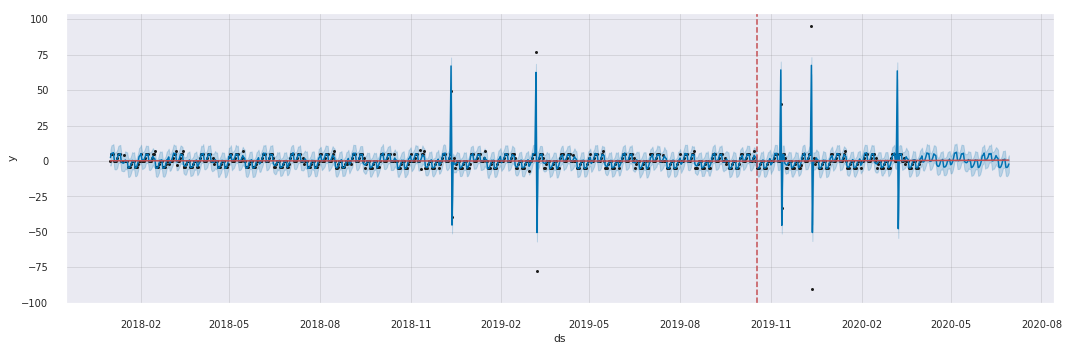

In [32]:
fig = plot(m, forecast, figsize=(15, 5))
add_changepoints_to_plot(fig.gca(), m, forecast)

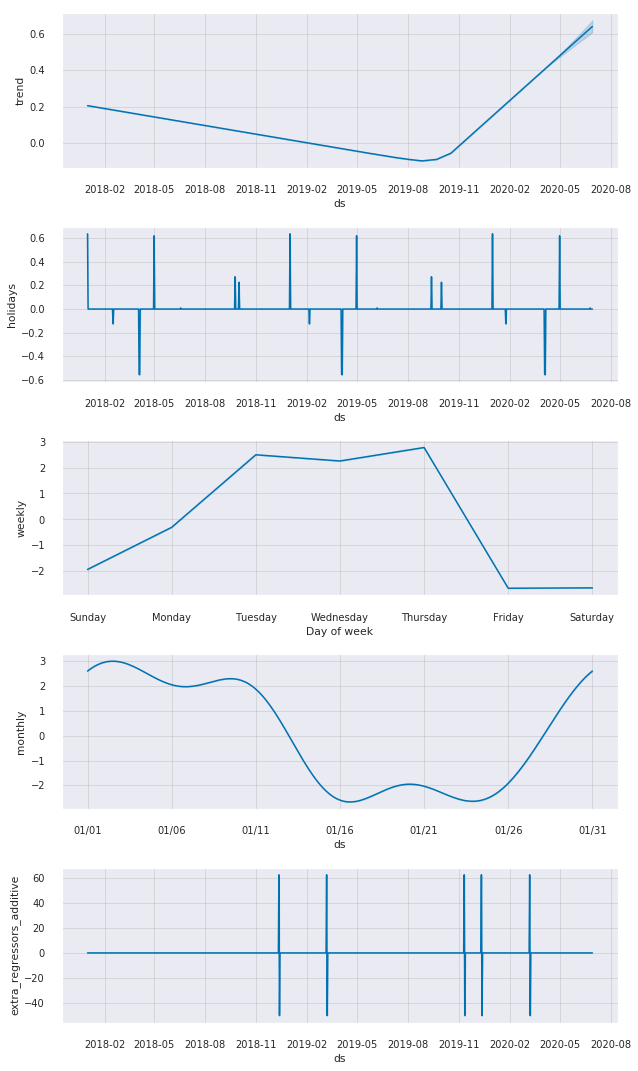

In [33]:
fig2 = m.plot_components(forecast)

In [35]:
df_input = df_input.merge(forecast, how='left', on='ds')

In [36]:
df_input['rmse'] = (df_input['yhat']-df_input['y'])**2
df_input['signed_rmse'] = df_input.apply(lambda row: (row['yhat']-row['y'])**2 if (row['yhat'] > row['y']) else -(row['yhat']-row['y'])**2, axis=1)

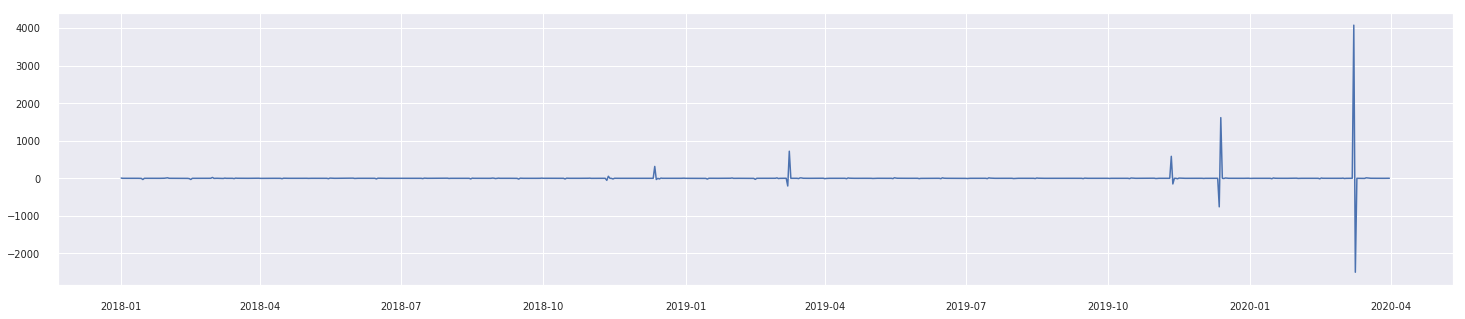

In [37]:
plt.figure(figsize=(25, 5))
plt.plot(df_input['ds'], df_input['signed_rmse'])

# Lollipop (moneymoji) Campaign
#plt.axvspan(datetime.strptime('2018-05-27', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-07', '%Y-%m-%d'), facecolor='#7a5c58', alpha=0.5)

# Travel (Jalan2) Jenius
#plt.axvspan(datetime.strptime('2018-10-17', '%Y-%m-%d'), datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'), facecolor='#99b2dd', alpha=0.5)
#plt.axvspan(datetime.strptime('2018-12-22', '%Y-%m-%d'), datetime.datetime.strptime('2019-01-15', '%Y-%m-%d'), facecolor='#b4869f', alpha=0.5)

# Mimpi2 Jenius
#plt.axvspan(datetime.strptime('2018-12-18', '%Y-%m-%d'), datetime.datetime.strptime('2019-01-31', '%Y-%m-%d'), facecolor='#9dfff9', alpha=0.5)

plt.show()

### LSTM
Inspired by [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

dataset = df_input['change'].astype(float).values.reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

In [8]:
dataset[:5]

array([[0.50091251],
       [0.50314156],
       [0.50314379],
       [0.50314602],
       [0.50089825]])

Splitting the data to train and test set

In [9]:
train_split = 2/3
train_set_size = int(len(dataset) * train_split)
test_set_size = len(dataset) - train_set_size

train, test = dataset[0:train_set_size, :], dataset[train_set_size:len(dataset), :]

In [10]:
print('Length of the train set: {:,} ({:.2f}%)\nLength of the test set: {:,} ({:.2f}%)'.format(
    len(train),
    train_split*100,
    len(test),
    (1-train_split)*100
))

Length of the train set: 547 (66.67%)
Length of the test set: 274 (33.33%)


In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=20, validation_split=0.25, batch_size=1, verbose=1)

Train on 408 samples, validate on 137 samples
Epoch 1/20
408/408 [==============================] - 2s 5ms/step - loss: 0.0369 - val_loss: 3.1378e-05
Epoch 2/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 2.9868e-05
Epoch 3/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 2.8805e-05
Epoch 4/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 3.1444e-05
Epoch 5/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 2.8306e-05
Epoch 6/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 3.1018e-05
Epoch 7/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 2.7977e-05
Epoch 8/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 4.2429e-05
Epoch 9/20
408/408 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 2.7447e-05
Epoch 10/20
408/40

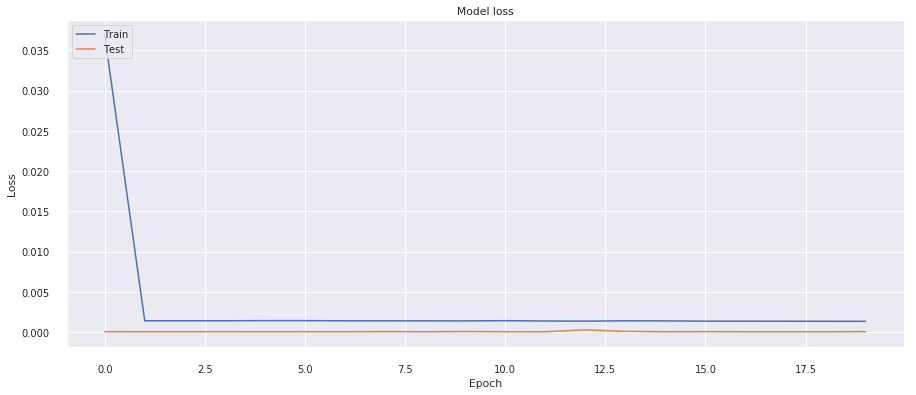

In [15]:
plt.figure(figsize=(15, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])

In [17]:
train_score = np.sqrt(mean_squared_error(trainY[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(testY[0], test_predict[:,0]))

print('Train Score: {:,.2f} RMSE\nTest Score: {:,.2f} RMSE'.format(
    train_score,
    test_score
))

Train Score: 65.12 RMSE
Test Score: 9.17 RMSE


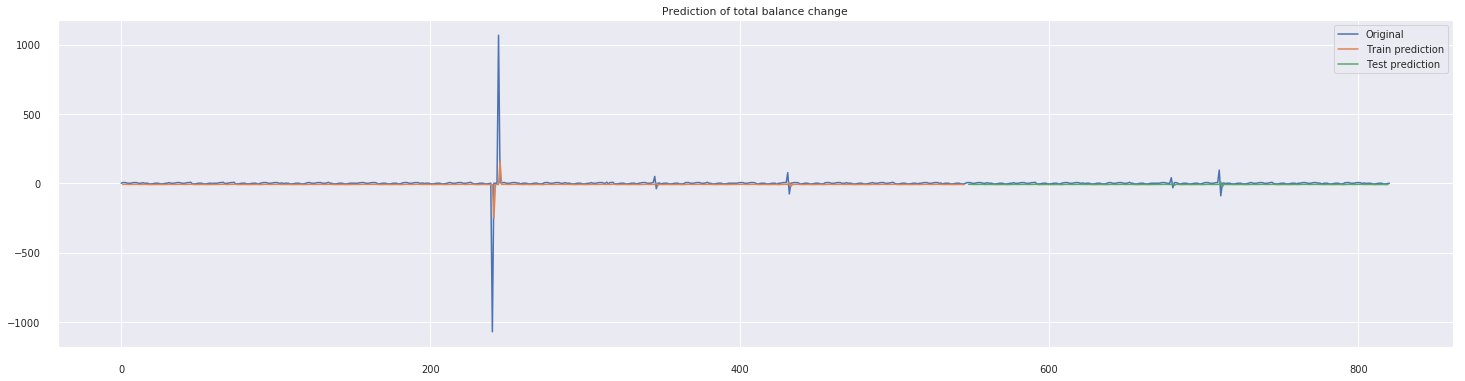

In [18]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(1, figsize=(25, 6))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='Train prediction')
plt.plot(testPredictPlot, label='Test prediction')
plt.legend()
plt.title('Prediction of total balance change')
plt.show()

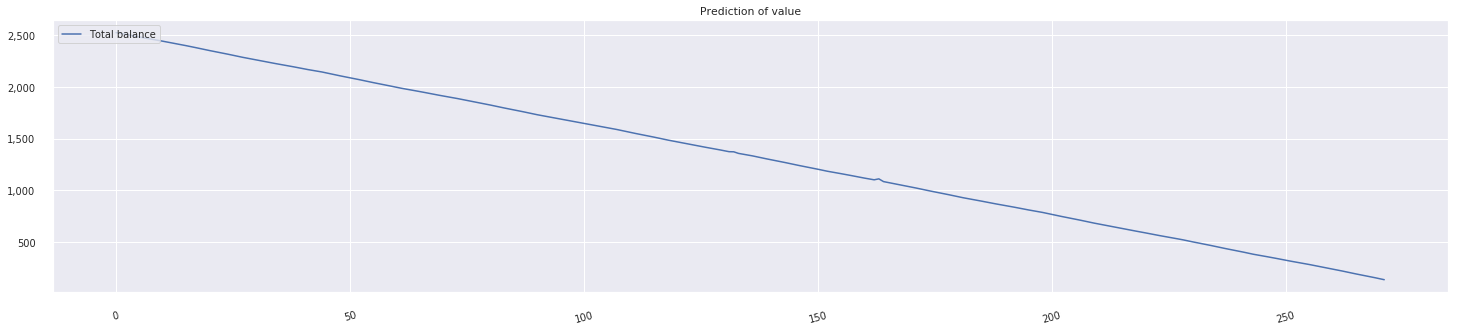

In [22]:
def restore_values_and_plot(change_series, first_value, title):
    df_plot = pd.DataFrame(data={'change': change_series, 'yhat': first_value})
    df_plot.dropna(subset=['change'], how='any', inplace=True)
    df_plot.reset_index(drop=False, inplace=True)

    for i in range(1, len(df_plot)):
        df_plot.loc[i, 'yhat'] = df_plot.loc[i-1, 'yhat'] + df_plot.loc[i, 'change']

    # Plot
    plt.figure(figsize=(25, 5))
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    plt.title(title)
    plt.plot(df_plot.index, df_plot['yhat'], label='Total balance')
    plt.xticks(rotation = 15)
    plt.legend(loc='upper left')
    plt.show()

restore_values_and_plot(testPredictPlot.flatten(), df_input.loc[0, 'value'], 'Prediction of value')

## Input data generator

In [7]:
amount_limits = [2000, 2200]
period = ['2018-01-01', '2020-04-01']
column_names = ['date', 'value']
number_of_change_points = np.random.randint(2, 4)

weekly_deviation_random = [50, 75]
monthly_deviation_random = [100, 150]
holiday_extra_percentage = 0.05
output_date_format = "%Y-%m-%d"

# Error generator
add_wrong_data = 1500 # False or a number
delete_lines = True

In [8]:
change_point_datetimes = []
change_point_values = []

print('Number of change points: {:}'.format(number_of_change_points))

days_difference = (datetime.strptime(period[-1], '%Y-%m-%d') - datetime.strptime(period[0], '%Y-%m-%d')).days
period_day_difference = int(days_difference/number_of_change_points)
print('Total length of output dataframe: {:}\nPeriod length in days: {:}\n'.format(
    days_difference,
    period_day_difference
))

df_output = pd.DataFrame(0, index=np.arange(days_difference), columns=['date', 'amount'])

for i in range(number_of_change_points):
    change_point_datetimes.append(
        datetime.strptime(period[0], '%Y-%m-%d') +
        (datetime.strptime(period[1], '%Y-%m-%d') - datetime.strptime(period[0], '%Y-%m-%d'))/number_of_change_points*i
    )

change_point_datetimes.append(
    datetime.strptime(period[-1], '%Y-%m-%d')
)

for i in range(number_of_change_points+1):
    change_point_values.append(np.random.randint(amount_limits[0], amount_limits[1]))
    print('Change point {:}.\n- Date: {:}\n- Value: {:}\n'.format(
        i+1,
        change_point_datetimes[i].strftime("%Y-%m-%d"),
        change_point_values[-1]
    ))

    df_output.loc[i*period_day_difference, 'date'] = change_point_datetimes[i]
    df_output.loc[i*period_day_difference, 'amount'] = change_point_values[-1]

j = 0
for i in range(1, days_difference):
    if change_point_datetimes[j+1] < df_output.loc[i-1, 'date']:
        j+= 1

    current_delta = (change_point_values[j+1]-change_point_values[j])/period_day_difference

    df_output.loc[i, 'date'] = df_output.loc[i-1, 'date'] + timedelta(days=1)
    df_output.loc[i, 'amount'] = df_output.loc[i-1, 'amount'] + current_delta

df_output['date'] = pd.to_datetime(df_output['date'])

Number of change points: 3
Total length of output dataframe: 821
Period length in days: 273

Change point 1.
- Date: 2018-01-01
- Value: 2052

Change point 2.
- Date: 2018-10-01
- Value: 2035

Change point 3.
- Date: 2019-07-02
- Value: 2021

Change point 4.
- Date: 2020-04-01
- Value: 2011



In [9]:
df_output['day'] = df_output['date'].dt.day
df_output['month_weight'] = df_output['day'].apply(lambda x: x if x < 15 else 31-x)
df_output['amount_monthly'] = df_output['amount']*(1 + (df_output['month_weight']+np.random.randint(monthly_deviation_random[0], monthly_deviation_random[1]))/1000)

In [10]:
df_output['dow'] = df_output['date'].dt.dayofweek
df_output['week_weight'] = df_output['dow'].apply(lambda x: x if x < 4 else 6-x)
df_output['amount_weekly'] = df_output['amount_monthly']*(1 + (df_output['week_weight']+np.random.randint(weekly_deviation_random[0], weekly_deviation_random[1]))/1000)

In [11]:
holidays = ['2018-03-08', '2018-11-11', '2018-12-12', '2019-03-08', '2019-11-11', '2019-12-12']
for i in holidays:
    df_output.loc[
        df_output[df_output['date'] == i].index,
        'amount_weekly'
    ] = (1 + (holiday_extra_percentage*np.random.randint(0, 100))/100)*df_output['amount_weekly']

In [12]:
if add_wrong_data:
    start = int(days_difference*np.random.uniform(0, 1))
    end = start + np.random.randint(2, 10)
    print('Adding error between {:} and {:}'.format(
        df_output.loc[start, 'date'],
        df_output.loc[end, 'date']
    ))

    df_output.loc[start:end, 'amount_weekly'] = add_wrong_data

Adding error between 2019-10-01 00:00:00 and 2019-10-05 00:00:00


In [13]:
df_output['amount_ma3'] = df_output['amount_weekly'].rolling(window=3).mean()

In [14]:
df_output[start-1:end+1]

,date,amount,day,month_weight,amount_monthly,dow,week_weight,amount_weekly,amount_ma3
637,2019-09-30,2017.626374,30,1,2225.441890,0,0,2356.742962,2359.665665
638,2019-10-01,2017.589744,1,1,2225.401487,1,1,1500.000000,2071.888472
639,2019-10-02,2017.553114,2,2,2227.378637,2,2,1500.000000,1785.580987
640,2019-10-03,2017.516484,3,3,2229.355714,3,3,1500.000000,1500.000000
641,2019-10-04,2017.479853,4,4,2231.332718,4,2,1500.000000,1500.000000
642,2019-10-05,2017.443223,5,5,2233.309648,5,1,1500.000000,1500.000000


In [15]:
df_output[:10]

,date,amount,day,month_weight,amount_monthly,dow,week_weight,amount_weekly,amount_ma3
0,2018-01-01,2052.000000,1,1,2263.356000,0,0,2396.894004,NaN
1,2018-01-02,2051.937729,2,2,2265.339253,1,1,2401.259608,NaN
2,2018-01-03,2051.875458,3,3,2267.322381,2,2,2405.629046,2401.260886
3,2018-01-04,2051.813187,4,4,2269.305385,3,3,2410.002318,2405.630324
4,2018-01-05,2051.750916,5,5,2271.288264,4,2,2409.836848,2408.489404
5,2018-01-06,2051.688645,6,6,2273.271018,5,1,2409.667279,2409.835482
6,2018-01-07,2051.626374,7,7,2275.253648,6,0,2409.493614,2409.665914
7,2018-01-08,2051.564103,8,8,2277.236154,0,0,2411.593087,2410.251327
8,2018-01-09,2051.501832,9,9,2279.218535,1,1,2415.971647,2412.352782
9,2018-01-10,2051.439560,10,10,2281.200791,2,2,2420.354039,2415.972924


In [17]:
if delete_lines:
    start = int(days_difference*np.random.uniform(0, 1))
    end = start + np.random.randint(2, 10)
    print('Deleting records between {:} and {:}'.format(
        df_output.loc[start, 'date'],
        df_output.loc[end, 'date']
    ))

    df_output.drop(index=df_output.loc[start:end].index, axis=0, inplace=True)

Deleting records between 2018-10-18 00:00:00 and 2018-10-22 00:00:00


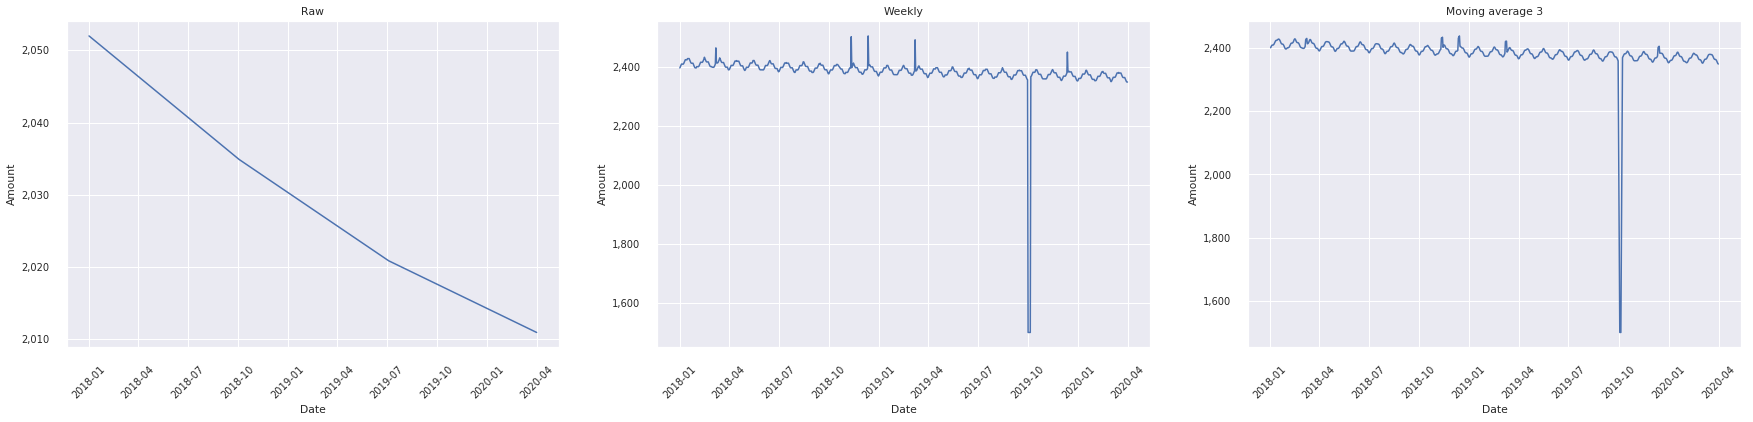

In [18]:
plt.figure(figsize=(30, 6))
sns.set(font_scale=0.9)

plt.subplot(1, 3, 1)
ax = sns.lineplot(x=df_output['date'], y=df_output['amount'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Amount')
ax.set_title('Raw')

plt.subplot(1, 3, 2)
ax = sns.lineplot(x=df_output['date'], y=df_output['amount_weekly'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Amount')
ax.set_title('Weekly')

plt.subplot(1, 3, 3)
ax = sns.lineplot(x=df_output['date'], y=df_output['amount_ma3'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Amount')
ax.set_title('Moving average 3')

plt.show()

In [19]:
df_output['date_str'] = df_output['date'].dt.strftime(output_date_format)

filename = 'data/output_{:}.csv'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
df_output[['date_str', 'amount_weekly']].rename(columns={'date_str': column_names[0], 'amount_weekly': column_names[1]}).to_csv(filename, index=False)
print('`' + str(filename) + '` saved')

`data/output_20200503144525.csv` saved
